<a href="https://colab.research.google.com/github/Amaljayaranga/NvidiaGenerator/blob/master/NvidiaGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!unzip  test.zip
#!unzip train.zip

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


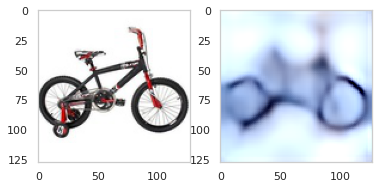

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


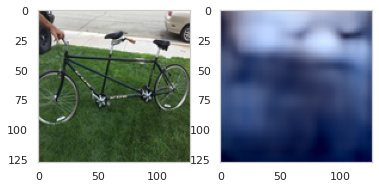

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


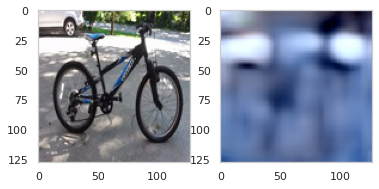

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


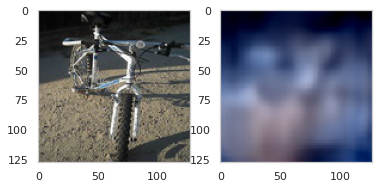

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


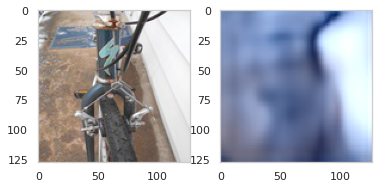

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


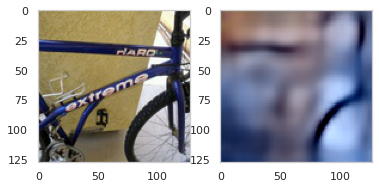

In [0]:
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch
from PIL import Image
from torchvision.datasets import MNIST
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from argparse import ArgumentParser
import seaborn as sns;sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
from argparse import ArgumentParser

Z_SIZE = 1024
IN_Channels = int(Z_SIZE/16)


parser = ArgumentParser(description='Simase Network')
parser.add_argument('--learning_batch_size', type=int, default=64)
parser.add_argument('--fc_in_features', type=int, default=512)
parser.add_argument('--fc_out_features', type=int, default=64)
parser.add_argument('--constractive_loss_margin', type=float, default=1.0)
parser.add_argument('--learning_rate', type=float, default=1e-3)
parser.add_argument('--num_epochs', type=int, default=500)
parser.add_argument('--weight_decay', type=float, default=1e-5)
parser.add_argument('--validation_split', type=float, default=0.2)
parser.add_argument('--mode', type=str, default='train')
parser.add_argument('--device', type=str, default='cuda')
parser.add_argument('--alpha', type=float, default=0.5)
args, unknown = parser.parse_known_args()


class PixelNorm(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(PixelNorm, self).__init__()
        self.epsilon = epsilon

    def forward(self, x):
        tmp = torch.mul(x, x)
        tmp = torch.rsqrt(torch.mean(tmp, dim=1, keepdim=True) + self.epsilon)
        return x * tmp

class Reshape(nn.Module):
    def __init__(self):
        super(Reshape, self).__init__()

    def forward(self, x):
        x = x.view(-1,IN_Channels,4,4)
        return x

class ConvBlock(nn.Module):

    def __init__(self,in_channel, out_channel):
        super(ConvBlock,self).__init__()

        self.conv = nn.Sequential(
                                    nn.Upsample(scale_factor=2, mode='nearest'),
                                    nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, stride=1, padding=1),
                                    nn.LeakyReLU(),
                                    PixelNorm(),
                                    nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, stride=1, padding=1),
                                    nn.LeakyReLU(),
                                    PixelNorm(),
                                    )
    def forward(self, x):
         x = self.conv(x)
         return x


class Encoder(nn.Module):

    def __init__(self):
        super(Encoder,self).__init__()

        encoder_pretrained = torchvision.models.densenet121(pretrained=True)
        features_pretrained = next(iter(encoder_pretrained.children()))

        self.encoder = torch.nn.Sequential()
        self.z_num_features = 0
        for name, module in features_pretrained.named_children():
            if name == 'norm5':
                self.z_num_features = module.num_features
            self.encoder.add_module(name, module)
        self.encoder.add_module('avg_pool', torch.nn.AdaptiveAvgPool2d(output_size=1))
        #z size = 1024

    def forward(self, x):
        z = self.encoder(x)
        return z

class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.initial = nn.Sequential(PixelNorm(),
                                     nn.Linear(Z_SIZE, Z_SIZE),
                                     nn.LeakyReLU(),
                                     PixelNorm(),
                                     Reshape(),
                                     nn.Conv2d(in_channels=IN_Channels, out_channels=IN_Channels, kernel_size=3, stride=1, padding=1),
                                     nn.LeakyReLU(),
                                     PixelNorm()
                                     )

        self.middle = nn.Sequential(ConvBlock(IN_Channels,IN_Channels), #8
                                    ConvBlock(IN_Channels,IN_Channels), #16
                                    ConvBlock(IN_Channels,IN_Channels), #32
                                    ConvBlock(IN_Channels,IN_Channels)) #64

        self.before_last_Conv = ConvBlock(IN_Channels,IN_Channels)#128-last

        self.before_last_Up =  nn.Sequential(
                                            nn.Conv2d(in_channels=IN_Channels, out_channels=3, kernel_size=1),
                                            nn.Upsample(scale_factor=2, mode='nearest')
                                             ) #128-before_last

        self.last = nn.Conv2d(in_channels=IN_Channels, out_channels=3, kernel_size=1)


    def forward(self, z):
        x = self.initial(z)
        x_m = self.middle(x)
        x_blm = self.before_last_Up(x_m)
        

        x_last = self.before_last_Conv(x_m)
        x_l = self.last(x_last)
        
        out = x_l*args.alpha + x_blm*(1-args.alpha)
        return out


class Full(nn.Module):

    def __init__(self):
        super(Full, self).__init__()

        self.encoder = Encoder()
        self.genarator = Generator()

    def forward(self, x):
        z = self.encoder(x)
        z = z.view(-1, Z_SIZE)
        out = self.genarator(z)
        return out
    

# Datasets from folders
data = {
    'train':
    datasets.ImageFolder(root='./tr/',
                         transform=transforms.Compose([transforms.ToTensor(),
                                                       #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                                       ])),
    'valid':
    datasets.ImageFolder(root='./te', transform=transforms.Compose([transforms.ToTensor(), 
                                                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                                                      ])),
}


dataloaders = {
    'train': DataLoader(data['train'], batch_size=32, shuffle=True),
    'valid': DataLoader(data['valid'], batch_size=32, shuffle=True)
}

DEVICE = args.device
if not torch.cuda.is_available():
    DEVICE = 'cpu'


model = Full()
model = model.to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

train = False
train_losses = []
eval_losses = []
epoches = []

train_loss_epoches = []
eval_loss_epoches = []

if train:
    print('Training started !!')
    for epoch in range(args.num_epochs):
        epoches.append(epoch)

        for image, label in iter(dataloaders['train']):
            image = image.to(DEVICE)
            output = model(image)
            loss = criterion(output,image)
            train_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('Epoch :', epoch+1, 'Training Loss:',np.mean(train_losses))
        train_loss_epoches.append(np.mean(train_losses))
        train_losses.clear()
       

        for image, label in iter(dataloaders['valid']):
            image = image.to(DEVICE)
            output = model(image)
            loss = criterion(output,image)
            eval_losses.append(loss.item())
        print('Epoch :', epoch+1, 'Eval Loss:',np.mean(eval_losses))
        eval_loss_epoches.append(np.mean(eval_losses))
        eval_losses.clear()

    #plotting
    plt.plot(epoches, train_loss_epoches, label="train")
    plt.plot(epoches, eval_loss_epoches, label="eval")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('training vs validation loss')
    plt.legend()
    plt.show()

    torch.save(model.to('cpu'), './nv500.pth')

def splot(img1,output):
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(transforms.ToPILImage()(img1[0]))
    out = output[0]
    npimg = out.detach().numpy()
    axarr[1].imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

if not train:
    model = torch.load('./nv500.pth')
    model.eval()
    for i in range(10):
      image, label = next(iter(dataloaders['train']))
      output = model(image)
      splot(image,output)

 



In [0]:
from PIL import Image
import os
import sys

path1 = "./test/1"
path2 = "./te/1"
#dirs = os.listdir( path )

for file_name in os.listdir(path1):
  print("Processing %s" % file_name)
  image = Image.open(os.path.join(path1, file_name))

  x,y = image.size
  new_dimensions = (128, 128)
  output = image.resize(new_dimensions, Image.ANTIALIAS)

  output_file_name = os.path.join(path2, "" + file_name)
  output.save(output_file_name, "JPEG", quality = 95)

print("All done")